In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df0 = pd.read_csv('df0.csv', index_col=0)
df0.sample(10, random_state = 10)

,text,duration,sum,okpd
0,,,,
1383673,"Выполнение работ по разработке проектно-сметной документации по благоустройству территории, расположенной по адресу: г.Москва, ЗАО, район Филевский парк, придомовая территория по ул. Новозаводская",15.0,2454360.77,71.1
503416,Выполнение работ по ремонту кровельного покрытия,7.0,1377000.00,41.2
587146,Выполнение работ по капитальному ремонту асфальтобетонного покрытия дорог в городе Боровск 2016 год (Реестровый номер: 805Э-02/16сб),13.0,11470841.59,42.1
870684,"Оказание услуг по благоустройству и озеленению территорий, прилегающих к административным зданиям Правительства Тверской области, для нужд ГБУ «УЭОАЗП» на 2017 год",15.0,4915949.82,71.1
2251621,Выполнение комплекса работ по содержанию муниципальных автомобильных дорог общего пользования местного значения Заветинского района Ростовской области в 2018 году,15.0,500000.00,42.1
447681,"Снятие, поверка и монтаж приборов учета тепловой энергии, горячего и холодного водоснабжения",7.0,84384.67,43.2
984882,Выполнение работ по обеспечению безопасности дорожного движения на территории городского округа Рошаль в 2017 году,15.0,873610.00,42.1
579515,Выполнение работ по модернизации конференц-системы зала заседаний Волгоградской городской Думы,13.0,8574521.32,43.2
997355,Образование 30 (тридцати) земельных участков из земель государственная собственность на которые не разграничена,7.0,74400.00,71.1


In [3]:
#из предыдущей главы
okpd_dict = {'43.2': 'Работы строительные специализированные',
             '71.1': 'Услуги в области архитектуры и инженерно-технического проектирования, технических испытаний, исследований и анализа',
             '42.1': 'Сооружения и строительные работы в области гражданского строительства',
             '41.2': 'Здания и работы по возведению зданий'}

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df0['label'] = label_encoder.fit_transform(df0['okpd'])

labels_dict = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Словарь окпд2=метка класса ", labels_dict)

Словарь окпд2=метка класса  {41.2: 0, 42.1: 1, 43.2: 2, 71.1: 3}


In [5]:
label2okpdname = {j: okpd_dict[str(i)] for i,j in labels_dict.items()}
print("Словарь метка класса: расшифровка ОКПД ")
print(*label2okpdname.items(), sep='\n')

Словарь метка класса: расшифровка ОКПД 
(0, 'Здания и работы по возведению зданий')
(1, 'Сооружения и строительные работы в области гражданского строительства')
(2, 'Работы строительные специализированные')
(3, 'Услуги в области архитектуры и инженерно-технического проектирования, технических испытаний, исследований и анализа')


In [6]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

from collections import Counter
from typing import List


# import nltk
# nltk.download('punkt')

import re
import string

In [8]:
objects = []

for sentence in tqdm(df0['text']):
    sentence = re.sub(r'[^\w\s]', ' ', sentence.lower())
    tokens = word_tokenize(sentence, language='russian')
    filtered_tokens = [token for token in tokens if token.isalpha()]
    objects.append(tokens)

print("Всего предложений:", len(objects))
print('Пример токенизированного: ',objects[101])

  0%|          | 0/61557 [00:00<?, ?it/s]

Всего предложений: 61557
Пример токенизированного:  ['оказание', 'услуг', 'по', 'содержанию', 'искусственных', 'сооружений', 'на', 'автомобильной', 'дороге', 'а', '376', 'хабаровск', 'лидога', 'ванино', 'комсомольск', 'на', 'амуре', 'хабаровский', 'край']


In [9]:
words = Counter()

for obj in tqdm(objects):
    for word in obj:
        words[word] += 1

print('Всего слов:', len(words))
print('Топ 10 встречающихся слов', *words.most_common(10))

  0%|          | 0/61557 [00:00<?, ?it/s]

Всего слов: 42448
Топ 10 встречающихся слов ('по', 50419) ('в', 33391) ('работ', 27115) ('выполнение', 25630) ('и', 25318) ('на', 19780) ('ул', 15172) ('ремонт', 12057) ('ремонту', 11378) ('г', 10573)


In [10]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 30000
words_common = set(word for word,_ in words.most_common(vocab_size))
vocab = vocab.union(words_common)

word2ind = {w: i for i, w in enumerate(vocab)}
ind2word = {i: w for w, i in word2ind.items()}

In [11]:
import pickle

with open('word2ind.pkl', 'wb') as f:
    pickle.dump(word2ind, f)

# with open('word2ind.pkl', 'rb') as f:
#     word2ind = pickle.load(f)


In [12]:
class FullDataset:
    def __init__(self, data, word2ind=word2ind, has_labels = True):
        self.data = data
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']
        self.word2ind = word2ind
        self.has_labels = has_labels

    def __getitem__(self, idx: int) -> dict:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation)
        )

        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            self.word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text, language="russian")
            if not word.isdigit()
        ]
        tokenized_sentence += [self.eos_id]

        if self.has_labels:

          train_sample = {
              "text": tokenized_sentence,
              "label": self.data[idx]['label'],
              "duration": self.data[idx]['duration'],  # Добавляем длительность контракта
              "sum": self.data[idx]['sum']  # Добавляем стоимость контракта
          }
        else:
          train_sample = {
                "input_ids": tokenized_sentence,
                "duration": self.data[idx]['duration'],  # Добавляем длительность контракта
                "sum": self.data[idx]['sum']  # Добавляем стоимость контракта
            }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch, word2ind = word2ind, pad_id=None, max_len=256):
    if pad_id is None:
        pad_id = word2ind['<pad>']

    # Подготовка для заполнения последовательностей
    if 'text' in input_batch[0]:
        # Если есть текст, работаем с текстом
        seq_lens = [len(x['text']) for x in input_batch]  # Длина последовательностей
        new_batch_text = [x['text'] for x in input_batch]
    else:
        # Если есть input_ids, работаем с ними
        seq_lens = [len(x['input_ids']) for x in input_batch]  # Длина последовательностей
        new_batch_text = [x['input_ids'] for x in input_batch]

    max_seq_len = min(max(seq_lens), max_len)

    padded_batch_text = []
    new_batch_duration = []
    new_batch_sum = []
    labels = []

    # Обрабатываем каждую последовательность
    for i, sequence in enumerate(input_batch):
        # Обрезка или дополнение последовательностей
        text = new_batch_text[i][:max_seq_len]
        text += [pad_id] * (max_seq_len - len(text))  # Добавление паддинга

        padded_batch_text.append(text)
        new_batch_duration.append(sequence['duration'])
        new_batch_sum.append(sequence['sum'])

        if 'label' in sequence:
            labels.append(sequence['label'])

    # Преобразуем списки в тензоры
    sequences = torch.LongTensor(padded_batch_text).to(device)
    durations = torch.FloatTensor(new_batch_duration).to(device)
    sums = torch.FloatTensor(new_batch_sum).to(device)

    # Проверка наличия меток
    if labels:
        labels = torch.LongTensor(labels).to(device)
        return {
            'input_ids': sequences,
            'duration': durations,
            'sum': sums,
            'label': labels
        }
    else:
        return {
            'input_ids': sequences,
            'duration': durations,
            'sum': sums
        }


In [13]:
train_dataset, valid_dataset = train_test_split(df0.drop(columns=['okpd']), test_size=0.2, shuffle = True, random_state = 33)
valid_dataset, test_dataset = train_test_split(valid_dataset, test_size=0.5, random_state = 33)

print('Обучающая выборка, train_dataset: ', train_dataset.shape)
print('Валидационная выборка, valid_dataset: ', valid_dataset.shape)
print('Тестовая выборка, test_dataset: ', test_dataset.shape)

Обучающая выборка, train_dataset:  (49245, 4)
Валидационная выборка, valid_dataset:  (6156, 4)
Тестовая выборка, test_dataset:  (6156, 4)


In [14]:
train_dataset = FullDataset(train_dataset.to_dict(orient='records'), word2ind)
eval_dataset = FullDataset(valid_dataset.to_dict(orient='records'), word2ind)
test_dataset = FullDataset(test_dataset.to_dict(orient='records'), word2ind)


batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [15]:
import seaborn as sns

sns.set(style="darkgrid")
paired_colors = sns.color_palette("Paired", 4)
paired_colors


def results_viz(model_name, num_epoch, acc_type, losses_type, best_params, output_name=None):
    """
    Визуализация результатов
    """
    epochs = np.arange(num_epoch)

    plt.figure(figsize = (12,4))

    plt.subplot(1,2,1)
    for (i, name) in enumerate(list(acc_type.keys())):
        accuracies=np.array(acc_type[name]) * 100
        acc_train, acc_valid = accuracies.T

        plt.plot(epochs, acc_train, color=paired_colors[i*2], label=f"{name} - train", marker='o', markersize=4, linewidth=2.5)
        plt.plot(epochs, acc_valid, color=paired_colors[i*2+1], label=f"{name} - valid", marker='o', markersize=4, linewidth=2.5)

        if best_params['aggregation_type'] == name:
            plt.text(best_params['epoch'], max(acc_valid)+0.2, f'{max(acc_valid):.2f}', fontsize=10, color=paired_colors[i*2+1], ha='center')
        print(f"Лучшая accuracy для подхода {name}: {max(acc_valid):.2f} valid, {max(acc_train):.2f} train")
    plt.title('Accuracy (Точность)')
    plt.xlabel("Epoch (Эпоха обучения)")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.75))
    plt.xticks(epochs, labels=[f'{epoch:.0f}' for epoch in epochs], fontsize=8)


    plt.subplot(1,2,2)
    for (i, name) in enumerate(list(losses_type.keys())):
        losses = losses_type[name]
        plt.plot(np.arange(len(losses)), losses, color=paired_colors[i*2], label=name, marker='o', markersize=4, linewidth=2.5)
    plt.title('Losses (Функция потери)')
    plt.xlabel("Epoch (Эпоха обучения)")
    plt.ylabel("Loss")
    plt.suptitle(model_name)
    plt.xticks(epochs, labels=[f'{epoch:.0f}' for epoch in epochs], fontsize=8)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    if output_name:
        plt.savefig(f'{output_name}.png')

    plt.show()

#Про визуализацию
# Эпохи (n) нумеруются  0...n-1
# Подразумевается, что результаты Accuracy\Losses считаются один раз в конце эпохи


In [16]:
def evaluate(model, eval_dataloader) -> float:
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model({
                'input_ids': batch['input_ids'],
                'duration': batch['duration'],
                'sum': batch['sum']
            })
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy, predictions


In [17]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

Используемое устройство: mps


In [18]:
class FullWordLM_LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.text_linear = nn.Linear(hidden_dim, hidden_dim)

        self.numeric_linear = nn.Linear(2, hidden_dim)  # 2 признака: duration и sum
        self.projection = nn.Linear(hidden_dim * 2, num_classes)  # Увеличили размерность для текста + числовых признаков
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch['input_ids'])  # [batch_size, seq_len, hidden_dim]
        rnn_output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            rnn_output = rnn_output.max(dim=1)[0]  # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            rnn_output = rnn_output.mean(dim=1)  # [batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        text_features = self.dropout(self.text_linear(self.non_lin(rnn_output)))  # [batch_size, hidden_dim]
        numeric_features = torch.stack([input_batch['duration'], input_batch['sum']], dim=1)  # [batch_size, 2]
        numeric_features = self.dropout(self.non_lin(self.numeric_linear(numeric_features)))  # [batch_size, hidden_dim]
        combined_features = torch.cat([text_features, numeric_features], dim=1)  # [batch_size, hidden_dim * 2]
        prediction = self.projection(self.non_lin(combined_features))  # [batch_size, num_classes]

        return prediction


    def predict_one(self, text: str, duration: float, sum_value: float, word2ind: dict, max_len: int = 256) -> str:
        """
        Прогнозирует класс и вероятности для одного примера с использованием текста, duration и sum.
        """

        processed_text = text.lower().translate(str.maketrans('', '', string.punctuation))
        tokenized_sentence = [word2ind.get(word, word2ind.get('<unk>')) for word in word_tokenize(processed_text, language="russian")]

        bos_id = word2ind.get('<bos>')
        eos_id = word2ind.get('<eos>')
        tokenized_sentence = [bos_id] + tokenized_sentence

        if len(tokenized_sentence) > max_len -1:
            tokenized_sentence = tokenized_sentence[:max_len-1]
        tokenized_sentence = tokenized_sentence + [eos_id]

        input_ids = torch.tensor(tokenized_sentence).unsqueeze(0)
        duration_tensor = torch.tensor([duration], dtype=torch.float32)
        sum_tensor = torch.tensor([sum_value], dtype=torch.float32)

        input_batch = {
            'input_ids': input_ids.to(next(self.parameters()).device),  
            'duration': duration_tensor.to(next(self.parameters()).device),
            'sum': sum_tensor.to(next(self.parameters()).device)
        }

        self.eval()
        logits = self.forward(input_batch)
        probabilities = F.softmax(logits, dim=-1).squeeze(0) 
        predicted_class = torch.argmax(probabilities).item()
        probabilities = probabilities.tolist()        
        
        return predicted_class, probabilities



Обучение для типа аггрегации max


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 0, valid_accuracy 0.9271


Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 1, valid_accuracy 0.9301


Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Обучение для типа аггрегации mean


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 1, valid_accuracy 0.9318


Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 2, valid_accuracy 0.9334


Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 93.01 valid, 98.72 train
Лучшая accuracy для подхода mean: 93.34 valid, 98.65 train


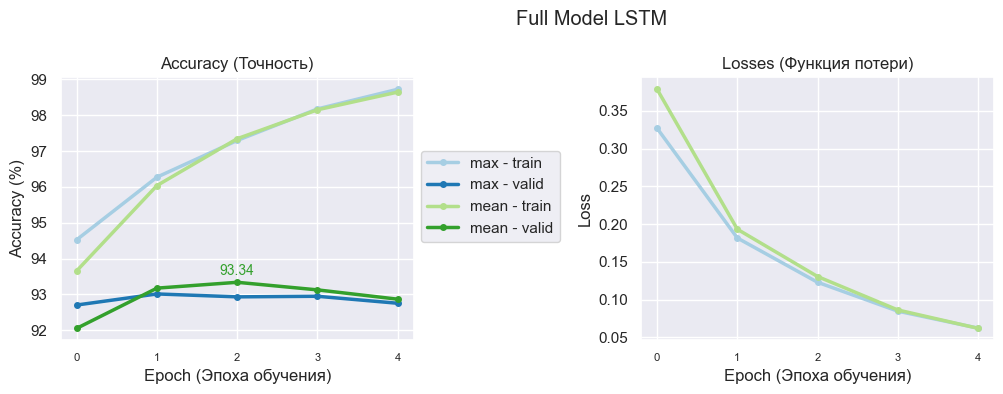

In [19]:
num_epoch = 5
best_eval_acc = float('-inf')
best_model_state = None
save_path = f"best_model.pt"
best_params = {'aggregation_type': None, 'epoch': None}

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Обучение для типа аггрегации {aggregation_type}")
    losses, acc = [], []
    model = FullWordLM_LSTM(hidden_dim=256, num_classes=len(labels_dict), vocab_size=len(vocab),aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Эпоха обучения {epoch}')):
            optimizer.zero_grad()
            logits = model({'input_ids': batch['input_ids'],'duration': batch['duration'],'sum': batch['sum']})
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        model.eval()
        current_accuracy_valid,_ = evaluate(model, eval_dataloader)
        current_accuracy_train,_ = evaluate(model, train_dataloader)
        acc.append([current_accuracy_train, current_accuracy_valid])

        if current_accuracy_valid > best_eval_acc:
            best_eval_acc = current_accuracy_valid
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            print(f"Лучшая модель сохранена: эпоха {epoch}, valid_accuracy {best_eval_acc:.4f}")
            best_params['aggregation_type'] = aggregation_type
            best_params['epoch'] = epoch

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

results_viz('Full Model LSTM', num_epoch, acc_type, losses_type, best_params)

In [20]:
model_full_lstm = FullWordLM_LSTM(hidden_dim=256, num_classes = len(labels_dict), vocab_size=len(vocab), aggregation_type=best_params['aggregation_type']).to(device)
# save_path = f"best_model.pt"
model_full_lstm.load_state_dict(torch.load(save_path, weights_only=True))
model_full_lstm.eval()

accuracy_valid,_ = evaluate(model_full_lstm, eval_dataloader)
accuracy_test, predictions_test = evaluate(model_full_lstm, test_dataloader)



print(f'Точность на валидационной выборке: {accuracy_valid:.4f}')
print(f'Точность на тестовой выборке: {accuracy_test:.4f}')

# predictions_test = predictions_test.tolist()
# f1_weighted = f1_score(y_test, predictions_test, average='weighted')
# print(f'F1(weighted) на тестовой выборке: {f1_weighted:.4f}')

print(f"\nЛучшая модель - лучшие параметры: aggregation_type {best_params['aggregation_type']}, epoch {best_params['epoch']}")


Точность на валидационной выборке: 0.9334
Точность на тестовой выборке: 0.9212

Лучшая модель - лучшие параметры: aggregation_type mean, epoch 2


In [21]:

text = "Выполнение работ по оказанию услуг"
duration = 12.5
sum_value = 1500.75

label, probs = model_full_lstm.predict_one(text, duration, sum_value, word2ind)
print(label, label2okpdname[label])
print(probs)


2 Работы строительные специализированные
[0.00043077929876744747, 0.16388091444969177, 0.8106086850166321, 0.02507968619465828]


In [32]:
import pickle

data_to_save = {
    'model': model_full_lstm,
    'word2ind': word2ind,
    'labels_dict':labels_dict,
    'label2okpdname': label2okpdname
}


with open('model_with_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)


----


# Восстановление всего!

In [1]:
# pip install torch

  Using cached torch-2.5.0-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.1 MB 393.8 kB/s eta 0:08:36
   ---------------------------------------- 0.1/203.1 MB 819.2 kB/s eta 0:04:08
   ---------------------------------------- 0.2/203.1 MB 1.1 MB/s eta 0:03:10
   ---------------------------------------- 0.3/203.1 MB 1.1 MB/s eta 0:03:01
   ---------------------------------------- 0.3/203.1 MB 1.2 MB/s eta 0:02:50
   ---------------------------------------- 0.4/203.1 MB 1.3 MB/s eta 0:02:39
   ---------------------------------------- 0.5/203.1 MB 1.3 MB/s eta 0:02:38
   ---------------------------------------- 0.6/203.1 MB 1.4 MB/s eta 0:02:26
   ---------------------------------------- 0.7/203.1 MB 1.4 MB/s eta 0:02:20
   -----------------

In [2]:
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

from collections import Counter
from typing import List


# import nltk
# nltk.download('punkt')

import re
import string

In [5]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [3]:
class FullWordLM_LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.text_linear = nn.Linear(hidden_dim, hidden_dim)

        self.numeric_linear = nn.Linear(2, hidden_dim)  # 2 признака: duration и sum
        self.projection = nn.Linear(hidden_dim * 2, num_classes)  # Увеличили размерность для текста + числовых признаков
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch['input_ids'])  # [batch_size, seq_len, hidden_dim]
        rnn_output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            rnn_output = rnn_output.max(dim=1)[0]  # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            rnn_output = rnn_output.mean(dim=1)  # [batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        text_features = self.dropout(self.text_linear(self.non_lin(rnn_output)))  # [batch_size, hidden_dim]
        numeric_features = torch.stack([input_batch['duration'], input_batch['sum']], dim=1)  # [batch_size, 2]
        numeric_features = self.dropout(self.non_lin(self.numeric_linear(numeric_features)))  # [batch_size, hidden_dim]
        combined_features = torch.cat([text_features, numeric_features], dim=1)  # [batch_size, hidden_dim * 2]
        prediction = self.projection(self.non_lin(combined_features))  # [batch_size, num_classes]

        return prediction


    def predict_one(self, text: str, duration: float, sum_value: float, word2ind: dict, max_len: int = 256) -> str:
        """
        Прогнозирует класс и вероятности для одного примера с использованием текста, duration и sum.
        """

        processed_text = text.lower().translate(str.maketrans('', '', string.punctuation))
        tokenized_sentence = [word2ind.get(word, word2ind.get('<unk>')) for word in word_tokenize(processed_text, language="russian")]

        bos_id = word2ind.get('<bos>')
        eos_id = word2ind.get('<eos>')
        tokenized_sentence = [bos_id] + tokenized_sentence

        if len(tokenized_sentence) > max_len -1:
            tokenized_sentence = tokenized_sentence[:max_len-1]
        tokenized_sentence = tokenized_sentence + [eos_id]

        input_ids = torch.tensor(tokenized_sentence).unsqueeze(0)
        duration_tensor = torch.tensor([duration], dtype=torch.float32)
        sum_tensor = torch.tensor([sum_value], dtype=torch.float32)

        input_batch = {
            'input_ids': input_ids.to(next(self.parameters()).device),  
            'duration': duration_tensor.to(next(self.parameters()).device),
            'sum': sum_tensor.to(next(self.parameters()).device)
        }

        self.eval()
        logits = self.forward(input_batch)
        probabilities = F.softmax(logits, dim=-1).squeeze(0) 
        predicted_class = torch.argmax(probabilities).item()
        probabilities = probabilities.tolist()        
        
        return predicted_class, probabilities



In [13]:
best_model = FullWordLM_LSTM(hidden_dim=256, num_classes = 4, vocab_size=30004, aggregation_type='mean').to(device)
save_path = r'..\models\best_model.pt'
# model_full_lstm.load_state_dict(torch.load(save_path, weights_only=True))

best_model.load_state_dict(torch.load(save_path, weights_only=True, map_location='cpu'))
best_model.eval()


FullWordLM_LSTM(
  (embedding): Embedding(30004, 256)
  (rnn): LSTM(256, 256, batch_first=True)
  (text_linear): Linear(in_features=256, out_features=256, bias=True)
  (numeric_linear): Linear(in_features=2, out_features=256, bias=True)
  (projection): Linear(in_features=512, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [25]:
df0[df0['label']==3]

,text,duration,sum,okpd,label
0,,,,,
1379,Выполнение кадастровых работ и постановку на кадастровый учет зданий,15.0,169150.00,71.1,3
1978,Выполнение работ по разработке проектно-сметных документаций на подключение контейнерных дизельных электростанций к административным зданиям Клиентской службы (на правах группы) в Юстинском районе ОПФР по Республике Калмыкия и Клиентской службы (на правах группы) в Приютненском районе ОПФР по Республике Калмыкия,14.0,130000.00,71.1,3
2010,Изготовление технического паспорта и технического плана административного здания Яшалтинского районного суда Республики Калмыкия,14.0,63172.63,71.1,3
2105,Выполнение проектно-сметных работ по монтажу ОПС в здании прокуратуры Прикубанского района (244.226.99),7.0,64740.00,71.1,3
2233,Оказание услуг по метрологической поверке приборов радиационного контроля,6.0,499500.00,71.1,3
...,...,...,...,...,...
2523099,Выполнение работ (услуг) по межеванию и постановке на кадастровый учет 37 земельных участков под индивидуальное жилищное строительство,7.0,37587.71,71.1,3
2523101,Оказание услуг по разработке программы комплексного развития социальной инфраструктуры Ильского городского поселения Северского района Краснодарского края.,7.0,17835.82,71.1,3
2523102,Оказание услуг по разработке программы комплексного развития транспортной инфраструктуры Ильского городского поселения Северского района Краснодарского края.,7.0,26755.83,71.1,3


In [34]:
# text = 'Выполнение кадастровых работ и постановку на кадастровый учет зданий'
# duration = 14
# sum_value = 1700000

text = 'Оказание услуг по разработке проектов организации дорожного движения на автомобильные дороги местного значения муниципального образования Темрюкский район'
duration = 7
sum_value = 45000

label, probs = best_model.predict_one(text, duration, sum_value, word2ind)
print('Классификация: ', label, label2okpd[label], label2okpdname[label])
print('Вероятности классов: ', probs)

Классификация:  3 71.1 Услуги в области архитектуры и инженерно-технического проектирования, технических испытаний, исследований и анализа
Вероятности классов:  [6.972162736929022e-06, 0.0014568361220881343, 8.686361070431303e-06, 0.9985274076461792]


In [28]:
df0[df0['label']==0]

,text,duration,sum,okpd,label
0,,,,,
501,"Текущий ремонт туалета, части инженерных сетей цокольного этажа Медицинского колледжа ФГБОУ ВО БГМУ Минздрава России",14.0,564534.54,41.2,0
1553,Капитальный ремонт санузла Лакской межрайонной прокуратуры Республики Дагестан,17.0,205003.00,41.2,0
1554,Капитальный ремонт санузла прокуратуры Рутульского района Республики Дагестан,17.0,200480.00,41.2,0
1555,Газификация здания прокуратуры Ахтынского района Республики Дагестан,17.0,80680.00,41.2,0
1673,"Капитальный ремонт отдельного батальона ППСП МО МВД России \Сунженский\"" """,6.0,3536434.00,41.2,0
...,...,...,...,...,...
2523182,Капитальный ремонт помещения 25 в здании МБОУ СОШ №5 в пос.Рассвет Староминского района,13.0,1635146.35,41.2,0
2523205,"Капитальный ремонт зрительного зала в ст.Староминской по ул.Калинина, 2",13.0,5100606.42,41.2,0
2523206,"Капитальный ремонт зрительного зала в ст.Староминской по ул.Калинина, 2",13.0,5100606.42,41.2,0


In [36]:
text = 'Текущий ремонт туалета, части инженерных сетей цокольного этажа Медицинского колледжа ФГБОУ ВО БГМУ Минздрава России'
duration = 14
sum_value = 5_645_355

# text = 'Выполнение дополнительных работ по объекту: Капитальный ремонт фасада и кровли здания муниципального бюджетного учреждения культуры \Межпоселенческий районный Дом культуры имени В.М.Толстых\" муниципального образования Тимашевский район"'
# duration = 5
# sum_value = 2_855_915

label, probs = best_model.predict_one(text, duration, sum_value, word2ind)
print('Классификация: ', label, label2okpdname[label])
print('Вероятности классов: ', probs)

Классификация:  0 Здания и работы по возведению зданий
Вероятности классов:  [0.9988211989402771, 6.332484190352261e-06, 0.0011660419404506683, 6.3681059145892505e-06]


In [37]:
df0[df0['label']==1]

,text,duration,sum,okpd,label
0,,,,,
6177,Оказание услуг по предоставлению мест стоянки служебных автотранспортных средств,6.0,2.016000e+05,42.1,1
10781,Выполнение работ по содержанию действующей сети автомобильных дорог общего пользования федерального значения. Замена барьерного ограждения,16.0,2.292297e+07,42.1,1
12001,"Оказание услуг по содержанию искусственных сооружений на автомобильной дороге А-376 Хабаровск – Лидога - Ванино – Комсомольск-на-Амуре, Хабаровский край",7.0,1.345841e+08,42.1,1
12949,выполнение работ по текущему ремонту железнодорожного пути необщего пользования для нужд ФКУ ИК-6 УФСИН России по Астраханской области,7.0,8.390573e+05,42.1,1
12950,выполнение работ по текущему ремонту железнодорожного пути необщего пользования для нужд ФКУ ИК-6 УФСИН России по Астраханской области,7.0,8.390573e+05,42.1,1
...,...,...,...,...,...
2523558,Ремонт ул. Центральной от дома №88 до дома №116 в х.Ленинский,7.0,2.351945e+06,42.1,1
2523559,Ремонт ул. Центральной от дома №88 до дома №116 в х.Ленинский,7.0,2.351945e+06,42.1,1
2523560,Ремонт ул. Центральной от дома №88 до дома №116 в х.Ленинский,7.0,2.351945e+06,42.1,1


In [38]:
text = 'Выполнение работ по профилированию гравийных дорог на территории Тимашевского городского поселения Тимашевского района'
duration = 7
sum_value = 2458290

label, probs = best_model.predict_one(text, duration, sum_value, word2ind)
print('Классификация: ', label, label2okpdname[label])
print('Вероятности классов: ', probs)

Классификация:  1 Сооружения и строительные работы в области гражданского строительства
Вероятности классов:  [2.9213078960310668e-06, 0.9999940395355225, 2.8391893920343136e-06, 2.876537052998174e-07]


In [39]:
df0[df0['label']==2]

,text,duration,sum,okpd,label
0,,,,,
394,прочая закупка услуг (услуги по монтажу и пусконаладке вытяжных систем вентиляции в производственных помещениях раскройного участка швейного цеха),14.0,248515.44,43.2,2
460,выполнение работ по монтажу средств тревожной сигнализации в зданиях Стерлитамакского филиала БашГУ,15.0,485952.92,43.2,2
1212,Замена труб отопления,7.0,142000.00,43.2,2
1242,Оказание услуг по техническому обслуживанию и регламентно-профилактический ремонт индивидуальных тепловых пунктов,7.0,688555.00,43.2,2
1243,Оказание услуг по техническому обслуживанию лифтов,7.0,132000.00,43.2,2
...,...,...,...,...,...
2523335,Приобретение и монтаж погружных насосов канализации в МАДОУ ДС КВ № 12,14.0,376743.85,43.2,2
2523339,"Обустройство инженерными коммуникациями (электрощитовой) муниципального имущества: г. Темрюк, ул. Ленина, 14",13.0,113360.00,43.2,2
2523372,Текущий ремонт внутренних туалетов,7.0,698354.68,43.2,2


In [42]:
# text = 'Установка дорожных знаков в Таманском сельском поселении Темрюкского района'
# duration = 7
# sum_value = 2688111

text = 'Обустройство инженерными коммуникациями (электрощитовой) муниципального имущества: г. Темрюк, ул. Ленина, 14	'
duration = 13
sum_value = 113_360

label, probs = best_model.predict_one(text, duration, sum_value, word2ind)
print('Классификация: ', label, label2okpdname[label])
print('Вероятности классов: ', probs)

Классификация:  2 Работы строительные специализированные
Вероятности классов:  [0.461352676153183, 6.788823520764709e-05, 0.5385327935218811, 4.672854993259534e-05]
